<a href="https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/SC_FEGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SC-FEGAN

It is a face editing softaware by Youngjoo Jo and Jongyoul Park check the paper in [arXive](https://arxiv.org/abs/1902.06838). It allows editting faces using masks, sketches and colors. The [implementation](https://github.com/JoYoungjoo/SC-FEGAN) is in TensorFlow and I just ported it to work in the browser using javascript and python. The system uses end-to-end convolutional neural network to generate the images taking a batch of four inputs 

*   **Masked Image** we use a mask to input incomplete image to the generator 
*   **Sketch** a binary image that represent sketches to guid the generator 
*   **Color** rgb image that can be used to add more control to the generated images. 
*   **Noise** a random input as a seed to the generator 

To train our the model, they used the CelebA-HQ dataset after several preprocessed as the following . First ran-domly select 2 sets of $29,000$ images for training and $1,000$
images for testing. Then the images are resized the images to $512 \times 512$ pixels
before attaining the sketch and color dataset.  The input training images are appended with 

*   **Masking** free-form masking with eye-positions. 
*   **Sketches** HED is used to create the sketches of the faces. 

The network architecture includes the generator and descriminator. 



*   **Generator** a simple U-Net model with all the conv layers replaced with gated convolutions. The [gated convolutoions](https://arxiv.org/abs/1806.03589) solve the issue of vanilla convolution that treats all input pixels as valid ones and generalize partial convolution by providing a learnable dynamic feature selection mechanism for each channel at each spatial location across all layer. 

*  **Descrinimator** has [SN-PatchGAN](https://arxiv.org/abs/1806.03589) structure with no ReLu applied to the GAN loss. 



![alt text](https://raw.githubusercontent.com/JoYoungjoo/SC-FEGAN/master/imgs/teaser.jpg)

# Download Model/Code

Download the code/model and combine, extract...

In [1]:
!git clone https://github.com/zaidalyafeai/SC-FEGAN
%cd SC-FEGAN
!cat x* > FC-FEGAN_ckpt.zip
!unzip FC-FEGAN_ckpt.zip

Cloning into 'SC-FEGAN'...
remote: Enumerating objects: 202, done.
remote: Total 202 (delta 0), reused 0 (delta 0), pack-reused 202
Receiving objects: 100% (202/202), 339.54 MiB | 12.43 MiB/s, done.
Resolving deltas: 100% (96/96), done.
/content/SC-FEGAN
Archive:  FC-FEGAN_ckpt.zip
  inflating: FC-FEGAN_ckpt/SC-FEGAN.ckpt.index  
  inflating: FC-FEGAN_ckpt/SC-FEGAN.ckpt.data-00000-of-00001  


In [0]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from utils.config import Config
from model import Model

Load configuration file, create the model and load the pretrained model. 

In [3]:
config = Config('demo.yaml') #configuration file 
model = Model(config) #warm up the model
model.load_demo_graph(config)#load the pretrained model

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Model loaded from FC-FEGAN_ckpt/SC-FEGAN.ckpt....start
Model loaded from FC-FEGAN_ckpt/SC-FEGAN.ckpt....end


# Helper Functions

create preprocessing functions, post processing and the input batch to the generator. 

In [0]:
#post process the image 
def post_process(result):
  result = (result+1)*127.5
  result = np.asarray(result[0,:,:,:],dtype=np.uint8)
  return result

#create some noise
def make_noise():
  noise = np.zeros([512, 512, 1],dtype=np.uint8)
  noise = cv2.randn(noise, 0, 255)
  noise = np.asarray(noise/255,dtype=np.uint8)
  noise = np.expand_dims(noise,axis=0)
  return noise

#create and preprocess thecolor image 
def make_stroke():
  stroke = np.zeros((512,512,3))
  stroke = stroke/127.5 - 1
  stroke = np.expand_dims(stroke,axis=0)
  return stroke

#create and preprocess the sketch image 
def make_sketch(path = 'canvas.png'):
  sketch = cv2.imread(path)
  if sketch is None:
    sketch = np.zeros((512,512, 1))
  else:
    sketch = sketch[:,:,::-1]
    indices = np.where((sketch[..., 0] < 255) & (sketch[..., 1] < 255) & (sketch[..., 2] == 255))
    sketch = np.zeros((512, 512, 1))
    sketch[indices] = 1
  sketch = np.asarray(sketch,dtype=np.uint8)
  sketch = np.expand_dims(sketch[..., 0:1],axis=0)
  return sketch

#load the original image 
def make_img(path = 'samples/00011.png'):
  img  = cv2.imread(path)[:,:,::-1]
  img  = np.expand_dims(img, 0)
  img  = img/127.5 - 1
  return img

#create the mask 
def make_mask(path = 'canvas.png'):
  mask = cv2.imread(path)
  if mask is None:
    mask = np.zeros((512,512, 1))
  else:
    mask = mask[:,:,::-1]
    mask[(mask[..., 0] > 0) & (mask[..., 0] > 0) & (mask[..., 2] > 0)] = 1
  
  mask = np.asarray(mask,dtype=np.uint8)
  mask = np.expand_dims(mask[..., 0:1],axis=0)
  
  return mask

#create a batch for the image 
def get_batch():
  img = make_img()
  mask  =  make_mask()
  sketch = make_sketch()*mask
  stroke = make_stroke()*mask
  noise = make_noise()*mask

  batch = np.concatenate([img, sketch, stroke, mask, noise],axis=3)
  return batch

#put the mask/sketch on the image 
def put_sketch_mask_on_image():
  img = post_process(make_img())
  mask = make_mask()
  mask = mask[0,...]
  sketch = make_sketch()
  sketch = sketch[0,...]
  
  return img * (1- mask)  + mask * 255

# Drawing
A simple drawing html app. Use the mask radio button to remove some parts and the storke to redraw some parts of the face. Note that the html file runs in your local machine so you the image needs to be uploaded to google colab. Hence, we are using a free hosting website to upload, then download the mask. 

In [60]:
%%html
<script src = "https://cdnjs.cloudflare.com/ajax/libs/EaselJS/1.0.2/easeljs.min.js"></script>
<script src="https://unpkg.com/axios/dist/axios.min.js"></script>
<canvas id="sheet2" width="512px" height="512px"></canvas>
<canvas id="sheet" width="512px" height="512px"></canvas>

<div style = 'margin-top: 512px; visibility:hidden;'>
  <button onclick = 'undo()'>Undo</button>
  <button onclick = 'clean()'>Clear</button>
</div>
<form name="myForm" >
  <input type="radio" name="myRadios" checked id = '0'>Mask (remove part of the image)<br>
  <input type="radio" name="myRadios" id = '1'>Stroke (draw on the mask)<br>
</form>

<button onclick = 'finish()'>Finish</button><br>
<textarea id = 'status' rows="1" cols="100" readonly="readonly">
click finish, then copy the link
</textarea><br>

<style>
canvas {
    position: absolute;
    top: 0;
    left: 0;
}
</style>
<script>

var canvas, canvas2, stage;
var drawingCanvas;
var oldPt;
var oldMidPt;
var color = "#ffffff";;
var stroke= 20;
var index;

function init() 
{
  var rad = document.myForm.myRadios;
  for (var i = 0; i < rad.length; i++) {
      rad[i].addEventListener('change', function() {
      if (this.id == '0')
      {
        color = '#ffffff';
        stroke = 20;
      }
      if (this.id == '1'){
        color = '#0000ff';
        stroke = 2;
      }
      });
}
  
  canvas = document.getElementById("sheet");
  canvas2 = document.getElementById("sheet2");
  var ctx = canvas2.getContext("2d");
  var img = new Image()
  const url = "https://raw.githubusercontent.com/JoYoungjoo/SC-FEGAN/master/samples/00011.png"
  img.src = url
  img.crossOrigin = "anonymous"
  img.onload = function () { 
    ctx.drawImage(img, 0, 0);
  }

  index = 0;

  //check to see if we are running in a browser with touch support
  stage = new createjs.Stage(canvas);
  stage.autoClear = false;
  stage.enableDOMEvents(true);

  createjs.Touch.enable(stage);
  createjs.Ticker.setFPS(24);

  drawingCanvas = new createjs.Shape();

  stage.addEventListener("stagemousedown", handleMouseDown);
  stage.addEventListener("stagemouseup", handleMouseUp);

  stage.addChild(drawingCanvas);
  stage.update();
}

function stop() {}

function clean(){
  stage.removeAllChildren();
  stage.update();
}
function handleMouseDown(event) {
  oldPt = new createjs.Point(stage.mouseX, stage.mouseY);
  oldMidPt = oldPt;
  stage.addEventListener("stagemousemove" , handleMouseMove);
}

//drawing handler 
function handleMouseMove(event) {
  var midPt = new createjs.Point(oldPt.x + stage.mouseX>>1, oldPt.y+stage.mouseY>>1);

  drawingCanvas.graphics.clear().setStrokeStyle(stroke, 'round', 'round').beginStroke(color).moveTo(midPt.x, midPt.y).curveTo(oldPt.x, oldPt.y, oldMidPt.x, oldMidPt.y);

  oldPt.x = stage.mouseX;
  oldPt.y = stage.mouseY;

  oldMidPt.x = midPt.x;
  oldMidPt.y = midPt.y;

  stage.update();
 
}

function handleMouseUp(event) {
  stage.removeEventListener("stagemousemove" , handleMouseMove);
}

function finish()
{
  
  // convert to blob to send
  canvas.toBlob(function(blob) {   
    upload_image(blob)
  });

}
  
 //upload to the server 
function upload_image(imgBlob){
             
   let cloud_url = 'https://api.cloudinary.com/v1_1/dfrhv4fhm/upload';
   let preset = 'ptr7pmx1';

    //var file = event.target.files[0];
    var formData = new FormData();
    formData.append('file', imgBlob);
    formData.append('upload_preset', preset);

    axios({

        url: cloud_url,
        method: 'POST',
        headers: {
            'Content-Type':'application/x-www-form-urlencoded'
        },
        data: formData
    }).then (function(res) {
        var textarea = document.getElementById("status");
        textarea.value = res.data.url;
        textarea.select();
    });
}
  
init();

</script>

Paste the link in the input text field

In [66]:
url = input('Paste the link from the text area above ')
!wget $url -O canvas.png

Paste the link from the text area above http://res.cloudinary.com/dfrhv4fhm/image/upload/v1554043853/ivyy9eymulqzxtixazao.png
--2019-03-31 14:52:00--  http://res.cloudinary.com/dfrhv4fhm/image/upload/v1554043853/ivyy9eymulqzxtixazao.png
Resolving res.cloudinary.com (res.cloudinary.com)... 151.101.1.137, 151.101.65.137, 151.101.129.137, ...
Connecting to res.cloudinary.com (res.cloudinary.com)|151.101.1.137|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10457 (10K) [image/png]
Saving to: ‘canvas.png’

canvas.png          100%[===================>]  10.21K  --.-KB/s    in 0s      

2019-03-31 14:52:00 (141 MB/s) - ‘canvas.png’ saved [10457/10457]



# Inference

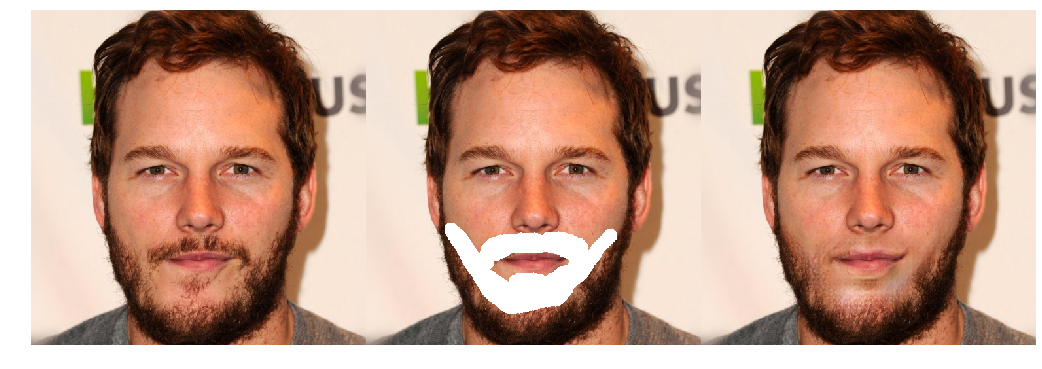

In [67]:
output = model.demo(config, get_batch()) #inference

plt.figure(figsize=(18,15))
plt.axis('off')
z = plt.imshow(np.concatenate([post_process(make_img()), put_sketch_mask_on_image(), post_process(output)], axis = 1))